In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from typing import List, Tuple

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml

import tqdm
tqdm.tqdm.pandas()
#plt.style.use('ggplot')

/nfs/staff-ssd/geisler/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

In [5]:
#mpl_latex.enable_production_mode()

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [163]:
labels_to_plot = [
    'Vanilla GCN',
    'Vanilla GDC',
    'SVD GCN',
    'SVD GCN (rank=50)',
    'SVD GCN (rank=100)',
    'Jaccard GCN',
    'RGCN',
    'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=1.0)',
    #'Soft Median GDC (T=0.5)',
    'Soft Median GDC (T=0.2)',
    'Soft Median GDC (T=5.0)',
    'Vanilla PPRGo',
    'Soft Medoid RPPRGo (T=0.5)',
    'Soft Median RPPRGo (T=0.5)'
]

In [8]:
dataset_map = {
    'cora_ml': r'\textbf{Cora ML}',#'~\citep{Bojchevski2018}}', # '\rotatebox{90}{Cora ML~\citep{Bojchevski2018}}',
    'citeseer': r'\textbf{Citeseer}',#~\citep{McCallum2000}}',
    'pubmed': r'\textbf{PubMed}',#~\citep{Sen2008}}',
    'ogbn-arxiv': r'\textbf{arXiv}',#~\citep{Hu2020}}',
    'ogbn-products': r'\textbf{Products}',#~\citep{Hu2020}}',
    'ogbn-papers100M': r'\textbf{Papers 100M}',#~\citep{Hu2020}}'
}
dataset_order = [dataset_map[k] for k in dataset_map.keys()]

In [9]:
attack_map = {
    'DICE': r'\textbf{DICE}',
    #'GANG': r'\textbf{GANG (ours)}',
    'FGSM': r'\textbf{greedy FGSM}',
    'GreedyRBCD': r'\textbf{GR-BCD (ours)}',
    'PGD': r'\textbf{PGD}',
    'PRBCD': r'\textbf{PR-BCD (ours)}'
}
attack_order = [attack_map[k] for k in attack_map.keys()]

In [34]:
attack_loss_map = {
    'FGSM': 'MCE',
    'GreedyRBCD': 'MCE',
    'PGD': 'tanhMargin',
    'PRBCD': 'tanhMargin'
}
attack_loss_map

{'FGSM': 'MCE',
 'GreedyRBCD': 'MCE',
 'PGD': 'tanhMargin',
 'PRBCD': 'tanhMargin'}

In [10]:
pm = r'\(\pm\)'
bpm = r'\(\boldsymbol{\pm}\)'

In [11]:
def make_max_bold(group):
    for col in list(group.columns):
        if not group[col].isna().all():
            idx = np.where(np.max(group[col].fillna("")) == group[col].fillna(""))[0]
            group.loc[group.index[idx], col] = rf'\textbf{{{group.loc[group.index[idx], col].iloc[0]}}}'\
                .replace(pm, bpm)
    return group

In [12]:
def make_second_best_underlined(group):
    for col in list(group.columns):
        if not group[col].isna().all() and np.unique(group[col].fillna("")).shape[0] > 1:
            second_max = np.unique(group[col].fillna("").apply(
                lambda v: v.replace(r'\textbf{', '').replace('}', '')
            ))[-2]
            idx = np.where(second_max == group[col].fillna(""))[0]
            group.loc[group.index[idx], col] = rf'\underline{{{group.loc[group.index[idx], col].iloc[0]}}}'
    return group

In [13]:
def mark_best_and_second_best(group: pd.DataFrame, 
                              first_mark: str = r'\textbf',
                              second_mark: str = r'\underline',
                              dimension: int = 0) -> pd.DataFrame:
    iterable  

In [14]:
def calc_mean_and_error(values: pd.Series, seeds: pd.Series, with_error=True, decimal_places: int = 3): 
    values, seeds = values.values, seeds.values
    seeds = seeds[~np.isnan(values)]
    values = values[~np.isnan(values)]

    idx = np.unique(seeds, return_index=True)[1]
    values = values[idx]
    
    if with_error:
        return rf'{np.mean(values):.{decimal_places}f} $\pm$ {np.std(values)/len(values):.{decimal_places}f}'
    else:
        return rf'{np.mean(values):.{decimal_places}f}'

In [15]:
from functools import partial

def _mark_best_and_second_best(vector: np.ndarray, 
                               first_mark: str = r'\textbf',
                               second_mark: str = r'\underline',
                               is_higher_better : bool = True) -> np.ndarray:
    vector = vector.astype(object)
    values = np.unique(vector[vector == vector])
    if not len(values):
        return vector
    
    if first_mark:
        if is_higher_better:
            mask = [vector == values[-1]]
        else:
            mask = [vector == values[0]]
        vector[mask] = np.char.add(np.char.add(first_mark + '{', vector[mask]), '}')
    if second_mark:
        if is_higher_better:
            mask = [vector == values[-2]]
        else:
            mask = [vector == values[1]]
        vector[mask] = np.char.add(np.char.add(second_mark + '{', vector[mask]), '}')
    return vector
    

def mark_best_and_second_best(df: pd.DataFrame, 
                              first_mark: str = r'\textbf',
                              second_mark: str = r'\underline',
                              axis: int = 0,
                              is_higher_better : bool = True) -> pd.DataFrame:
    df[:] = np.apply_along_axis(
        partial(_mark_best_and_second_best, first_mark=first_mark, 
                second_mark=second_mark, is_higher_better=is_higher_better),
        axis=axis,
        arr=df.values
    )
    return df

In [208]:
df_experiments = seml.get_results('neurips21_global_attack_transfer',
                                  to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])
df_experiments = df_experiments[df_experiments['config.attack'] != 'GANG']
df_experiments.head()

/nfs/homedirs/geisler/code/seml/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,batch_id,slurm.experiments_per_job,slurm.sbatch_options.time,slurm.sbatch_options.nodes,slurm.sbatch_options.cpus-per-task,slurm.sbatch_options.mem,slurm.sbatch_options.gres,config.overwrite,config.db_collection,config.dataset,config.data_dir,config.binary_attr,config.normalize,config.make_undirected,config.make_unweighted,config.normalize_attr,config.seed,config.attack,config.attack_params.loss_type,config.epsilons,config.artifact_dir,config.pert_adj_storage_type,config.pert_attr_storage_type,config.model_storage_type,config.model_label,config.surrogate_model_storage_type,config.surrogate_model_label,config.device,config.data_device,config.display_steps,result.results,config.attack_params.base_lr,config.attack_params.do_synchronize,config.attack_params.epochs,config.attack_params.fine_tune_epochs,config.attack_params.keep_heuristic,config.attack_params.search_space_size
0,1,1,1,0-01:00,1,4,4G,gpu:1,1,neurips21_global_attack_transfer,cora_ml,datasets/,False,False,True,True,False,0,FGSM,CE,"[0, 0.01, 0.05, 0.1, 0.25]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla Dense GCN,0,0,10,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,0-01:00,1,4,4G,gpu:1,2,neurips21_global_attack_transfer,cora_ml,datasets/,False,False,True,True,False,0,FGSM,CW,"[0, 0.01, 0.05, 0.1, 0.25]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla Dense GCN,0,0,10,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,0-01:00,1,4,4G,gpu:1,3,neurips21_global_attack_transfer,cora_ml,datasets/,False,False,True,True,False,0,FGSM,SCE,"[0, 0.01, 0.05, 0.1, 0.25]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla Dense GCN,0,0,10,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,0-01:00,1,4,4G,gpu:1,4,neurips21_global_attack_transfer,cora_ml,datasets/,False,False,True,True,False,0,FGSM,MCE,"[0, 0.01, 0.05, 0.1, 0.25]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla Dense GCN,0,0,10,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1,0-01:00,1,4,4G,gpu:1,5,neurips21_global_attack_transfer,cora_ml,datasets/,False,False,True,True,False,0,FGSM,tanhMargin,"[0, 0.01, 0.05, 0.1, 0.25]",cache,evasion_global_transfer_adj,evasion_global_transfer_attr,pretrained,None,pretrained,Vanilla Dense GCN,0,0,10,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
# df_experiments.to_csv('notebooks/kdd21_rgnn_at_scale_attack_evasion_transfer.csv')

In [209]:
df_experiments.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.time', 'slurm.sbatch_options.nodes',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.gres', 'config.overwrite', 'config.db_collection',
       'config.dataset', 'config.data_dir', 'config.binary_attr',
       'config.normalize', 'config.make_undirected', 'config.make_unweighted',
       'config.normalize_attr', 'config.seed', 'config.attack',
       'config.attack_params.loss_type', 'config.epsilons',
       'config.artifact_dir', 'config.pert_adj_storage_type',
       'config.pert_attr_storage_type', 'config.model_storage_type',
       'config.model_label', 'config.surrogate_model_storage_type',
       'config.surrogate_model_label', 'config.device', 'config.data_device',
       'config.display_steps', 'result.results',
       'config.attack_params.base_lr', 'config.attack_params.do_synchronize',
       'config.attack_params.epochs', 'config.attack_

In [210]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = experiment['config.dataset']
    df_result['attack'] = experiment['config.attack']
    df_result['seed'] = experiment['config.seed']
    df_result['batch_id'] = experiment['batch_id']
    df_result['novel_loss'] = (
        experiment['config.attack'] not in attack_loss_map
        or experiment['config.attack_params.loss_type'] == attack_loss_map[experiment['config.attack']]
    )
    df_result['lr'] = experiment['config.attack_params.base_lr']
    
df_results = pd.concat(df_results, ignore_index=True)
df_results = df_results.sort_values('batch_id')
df_results = df_results.drop_duplicates([
    c for c in df_results.columns if c != 'batch_id' and c != 'accuracy'
], keep='last')

df_results

,label,epsilon,accuracy,dataset,attack,seed,batch_id,novel_loss,lr
5091,Jaccard GCN,0.05,0.743874,cora_ml,PGD,1,1,True,0.001
5092,RGCN,0.05,0.745455,cora_ml,PGD,1,1,True,0.001
5093,Vanilla GCN,0.10,0.686166,cora_ml,PGD,1,1,True,0.001
5094,Vanilla Dense GCN,0.10,0.681818,cora_ml,PGD,1,1,True,0.001
5095,Vanilla GDC,0.10,0.690514,cora_ml,PGD,1,1,True,0.001
...,...,...,...,...,...,...,...,...,...
15448,Soft Median GDC (T=1.0),0.25,0.656126,cora_ml,PGD,0,3,False,0.100
15447,Soft Medoid GDC (T=0.5),0.25,0.739130,cora_ml,PGD,0,3,False,0.100
15446,Vanilla GDC,0.25,0.586957,cora_ml,PGD,0,3,False,0.100
15468,Vanilla GDC,0.01,0.816996,cora_ml,PGD,1,3,False,1.000


In [211]:
df_results.attack.unique()

array(['PGD', 'GreedyRBCD', 'PRBCD', 'DICE', 'FGSM'], dtype=object)

In [212]:
df_results.dataset.unique()

array(['cora_ml'], dtype=object)

In [213]:
df_results[df_results.dataset == 'cora_ml'].label.unique()

array(['Jaccard GCN', 'RGCN', 'Vanilla GCN', 'Vanilla Dense GCN',
       'Vanilla GDC', 'Soft Medoid GDC (T=0.5)', 'SVD GCN (rank=100)',
       'Soft Median GDC (T=1.0)', 'Soft Median GDC (T=0.2)',
       'SVD GCN (rank=50)', 'Soft Median GDC (T=0.5)'], dtype=object)

In [214]:
architecture_c = r'\textbf{Architecture}'
dataset_c = r'   '
attack_c = r'\textbf{Attack}'
epsilons_c = r'Frac. edges \(\boldsymbol{\epsilon}\)'

epsilons = [0.01, 0.05, 0.1] #[0.01, 0.05, 0.1, 0.25]
best_attack_mark = r'\textbf'
best_defense_mark = r'\underline'

In [215]:
def transform_label(label: str):
    return (
        label.replace('\n', ' ')
        .replace('RPPRGo', 'PPRGo')
        .replace(' (T=0.5)','')
        .replace(' (T=0.2)','')
        .replace(' (T=5.0)','')
    )

In [216]:
df_results['label'].apply(transform_label).unique()

array(['Jaccard GCN', 'RGCN', 'Vanilla GCN', 'Vanilla Dense GCN',
       'Vanilla GDC', 'Soft Medoid GDC', 'SVD GCN (rank=100)',
       'Soft Median GDC (T=1.0)', 'Soft Median GDC', 'SVD GCN (rank=50)'],
      dtype=object)

In [217]:
df = []

for (dataset, attack, label, epsilon), df_group in df_results[
    (df_results['novel_loss']
     | (df_results['attack'] == 'DICE')
     | (df_results['attack'] == 'GANG'))
    & df_results['label'].isin(labels_to_plot)
].groupby(['dataset', 'attack', 'label', 'epsilon']):
    if len(df_group.seed.unique()) != 3:
        print(f'For {dataset}-{attack}-{epsilon}-{label} collected runs for seed {df_group.seed.tolist()}')
    if label == 'Soft Median GDC (T=0.2)' and dataset == 'ogbn-products':
        continue
    if label == 'Soft Median GDC (T=5.0)' and dataset == 'ogbn-arxiv':
        continue

    values, seeds = df_group.accuracy.values, df_group.seed.values
    seeds = seeds[~np.isnan(values)]
    values = values[~np.isnan(values)]

    idx = np.unique(seeds, return_index=True)[1]
    accuracy = values[idx].mean()
    
    df.append({
        dataset_c: dataset_map[dataset],
        architecture_c: transform_label(label),
        attack_c: attack_map[attack],
        epsilons_c: epsilon,
        'accuracy': accuracy
    })
    
df = pd.DataFrame(df)

df = df[
    ~((df[attack_c] == attack_map['PGD']) & (df[dataset_c] == dataset_map['pubmed']))
    & ~((df[attack_c] == attack_map['FGSM']) & (df[dataset_c] == dataset_map['pubmed']))
    #& ~((df[architecture_c] == transform_label('Soft Medoid GDC (T=0.5)')) & (df[dataset_c] == dataset_map['pubmed']))
]

#df

In [218]:
df_accuracy = df[(df[epsilons_c] == 0) & (df[attack_c] == attack_map['PGD'])]
df_accuracy = df_accuracy.drop(columns=[attack_c, epsilons_c])
df_accuracy[dataset_c] = df_accuracy[dataset_c].apply(lambda dataset: rf'\rotatebox{{90}}{{{dataset}}}')
df_accuracy = df_accuracy.set_index([dataset_c, architecture_c])
df_accuracy.columns = pd.MultiIndex.from_product([['\textbf{Acc.}'], [' ']])

df[architecture_c] = df[architecture_c].astype("category")
df[architecture_c].cat.set_categories(
    list(dict.fromkeys([transform_label(l) for l in labels_to_plot]).keys()),
    inplace=True
)
df[dataset_c] = df[dataset_c].apply(lambda cat: rf'\rotatebox{{90}}{{{cat}}}').astype("category")
df[dataset_c].cat.set_categories(
    [rf'\rotatebox{{90}}{{{cat}}}' for cat in dataset_order],
    inplace=True
)

#df = df.sort_values([dataset_c, architecture_c])

df = df[df[epsilons_c].isin(epsilons)].copy()

df_piv = pd.pivot_table(
    df, 
    index=[dataset_c, architecture_c], 
    columns=[attack_c, epsilons_c], #['type', attack_c, ' '], 
    values='accuracy'#,
    #aggfunc=lambda x: ' '.join(x)
)

df_piv = df_piv[[c for attack in attack_order for c in df_piv.columns if c[0] == attack]]

df_piv = df_piv.join(df_accuracy, on=['   ', architecture_c])
df_piv = df_piv.apply(lambda row: row[-1] - row[:-1], axis=1).round(3)
   

In [219]:
df_piv

\textbf{Attack}                                        \textbf{DICE}         \
Frac. edges \(\boldsymbol{\epsilon}\)                           0.01   0.05   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                   0.003  0.011   
                                 Vanilla GDC                   0.002  0.012   
                                 SVD GCN (rank=50)             0.003  0.013   
                                 SVD GCN (rank=100)            0.230  0.013   
                                 Jaccard GCN                   0.003  0.009   
                                 RGCN                          0.004  0.012   
                                 Soft Medoid GDC               0.001  0.006   
                                 Soft Median GDC               0.002  0.006   

\textbf{Attack}                                                \
Frac. edges \(\boldsymbol{\epsilon}\)                    0.10   
                                 \textbf{Architecture}          
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN            0.018   
                                 Vanilla GDC            0.023   
                                 SVD GCN (rank=50)      0.028   
                                 SVD GCN (rank=100)     0.028   
                                 Jaccard GCN            0.015   
                                 RGCN                   0.023   
                                 Soft Medoid GDC        0.011   
                                 Soft Median GDC        0.012   

\textbf{Attack}                                        \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                          0.032   
                                 Vanilla GDC                          0.031   
                                 SVD GCN (rank=50)                   -0.001   
                                 SVD GCN (rank=100)                   0.003   
                                 Jaccard GCN                          0.027   
                                 RGCN                                 0.026   
                                 Soft Medoid GDC                      0.012   
                                 Soft Median GDC                      0.014   

\textbf{Attack}                                                       \
Frac. edges \(\boldsymbol{\epsilon}\)                    0.05   0.10   
                                 \textbf{Architecture}                 
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN            0.115  0.186   
                                 Vanilla GDC            0.104  0.170   
                                 SVD GCN (rank=50)      0.010  0.029   
                                 SVD GCN (rank=100)     0.017  0.036   
                                 Jaccard GCN            0.096  0.156   
                                 RGCN                   0.100  0.166   
                                 Soft Medoid GDC        0.035  0.046   
                                 Soft Median GDC        0.043  0.061   

\textbf{Attack}                                        \textbf{GR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                    0.01   
                                 \textbf{Architecture}                          
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                            0.037   
                                 Vanilla GDC                            0.031   
                                 SVD GCN (rank=50)                      0.002   
                                 SVD GCN (rank=100)                     0.005   
                                 Jaccard GCN                            0.029   
                                 RGCN                                   0.025   
                      

In [220]:
df_piv.join(df_accuracy.round(2), on=['   ', architecture_c])

\textbf{Attack}                                        \textbf{DICE}         \
Frac. edges \(\boldsymbol{\epsilon}\)                           0.01   0.05   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                   0.003  0.011   
                                 Vanilla GDC                   0.002  0.012   
                                 SVD GCN (rank=50)             0.003  0.013   
                                 SVD GCN (rank=100)            0.230  0.013   
                                 Jaccard GCN                   0.003  0.009   
                                 RGCN                          0.004  0.012   
                                 Soft Medoid GDC               0.001  0.006   
                                 Soft Median GDC               0.002  0.006   

\textbf{Attack}                                                \
Frac. edges \(\boldsymbol{\epsilon}\)                     0.1   
                                 \textbf{Architecture}          
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN            0.018   
                                 Vanilla GDC            0.023   
                                 SVD GCN (rank=50)      0.028   
                                 SVD GCN (rank=100)     0.028   
                                 Jaccard GCN            0.015   
                                 RGCN                   0.023   
                                 Soft Medoid GDC        0.011   
                                 Soft Median GDC        0.012   

\textbf{Attack}                                        \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                          0.032   
                                 Vanilla GDC                          0.031   
                                 SVD GCN (rank=50)                   -0.001   
                                 SVD GCN (rank=100)                   0.003   
                                 Jaccard GCN                          0.027   
                                 RGCN                                 0.026   
                                 Soft Medoid GDC                      0.012   
                                 Soft Median GDC                      0.014   

\textbf{Attack}                                                       \
Frac. edges \(\boldsymbol{\epsilon}\)                    0.05    0.1   
                                 \textbf{Architecture}                 
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN            0.115  0.186   
                                 Vanilla GDC            0.104  0.170   
                                 SVD GCN (rank=50)      0.010  0.029   
                                 SVD GCN (rank=100)     0.017  0.036   
                                 Jaccard GCN            0.096  0.156   
                                 RGCN                   0.100  0.166   
                                 Soft Medoid GDC        0.035  0.046   
                                 Soft Median GDC        0.043  0.061   

\textbf{Attack}                                        \textbf{GR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                    0.01   
                                 \textbf{Architecture}                          
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                            0.037   
                                 Vanilla GDC                            0.031   
                                 SVD GCN (rank=50)                      0.002   
                                 SVD GCN (rank=100)                     0.005   
                                 Jaccard GCN                            0.029   
                                 RGCN                                   0.025   
                      

In [221]:
print(df_piv.join(df_accuracy.round(2), on=['   ', architecture_c]).to_markdown())

|                                                              |   ('\\textbf{DICE}', 0.01) |   ('\\textbf{DICE}', 0.05) |   ('\\textbf{DICE}', 0.1) |   ('\\textbf{greedy FGSM}', 0.01) |   ('\\textbf{greedy FGSM}', 0.05) |   ('\\textbf{greedy FGSM}', 0.1) |   ('\\textbf{GR-BCD (ours)}', 0.01) |   ('\\textbf{GR-BCD (ours)}', 0.05) |   ('\\textbf{GR-BCD (ours)}', 0.1) |   ('\\textbf{PGD}', 0.01) |   ('\\textbf{PGD}', 0.05) |   ('\\textbf{PGD}', 0.1) |   ('\\textbf{PR-BCD (ours)}', 0.01) |   ('\\textbf{PR-BCD (ours)}', 0.05) |   ('\\textbf{PR-BCD (ours)}', 0.1) |   ('\textbf{Acc.}', ' ') |
|:-------------------------------------------------------------|---------------------------:|---------------------------:|--------------------------:|----------------------------------:|----------------------------------:|---------------------------------:|------------------------------------:|------------------------------------:|-----------------------------------:|--------------------------:|--------

In [222]:
 best_defenses = []
for i in np.array(df_piv.index.get_level_values(0).unique()):
    df_slice = df_piv.loc[(i, slice(None))]
    best_defenses.append([df_slice[col].astype(float).argmin() for col in df_slice])

df_piv = df_piv.applymap(lambda val: str(val) if val == val else val)
for epsilon in epsilons:
    current_columns = [c for c in df_piv.columns if c[1] == epsilon]
    df_piv[current_columns] = df_piv[current_columns].groupby(dataset_c).apply(
        partial(mark_best_and_second_best, first_mark=best_attack_mark, second_mark='', axis=1, is_higher_better=True)
    )

for i, bests in zip(np.array(df_piv.index.get_level_values(0).unique()), best_defenses):
    df_slice = df_piv.loc[(i, slice(None))]
    for col, best in zip(df_slice, bests):
        if best == -1:
            continue
        df_slice.loc[df_slice.index[best], col] = rf'{best_defense_mark}{{{df_slice.loc[df_slice.index[best], col]}}}'
    

df_piv = df_piv.join(df_accuracy, on=['   ', architecture_c])
df_piv = df_piv.fillna('-')
df_piv

/nfs/staff-ssd/geisler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


\textbf{Attack}                                             \textbf{DICE}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                0.01   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.003   
                                 Vanilla GDC                        0.002   
                                 SVD GCN (rank=50)         \textbf{0.003}   
                                 SVD GCN (rank=100)         \textbf{0.23}   
                                 Jaccard GCN                        0.003   
                                 RGCN                               0.004   
                                 Soft Medoid GDC        \underline{0.001}   
                                 Soft Median GDC                    0.002   

\textbf{Attack}                                                            \
Frac. edges \(\boldsymbol{\epsilon}\)                                0.05   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.011   
                                 Vanilla GDC                        0.012   
                                 SVD GCN (rank=50)                  0.013   
                                 SVD GCN (rank=100)                 0.013   
                                 Jaccard GCN                        0.009   
                                 RGCN                               0.012   
                                 Soft Medoid GDC        \underline{0.006}   
                                 Soft Median GDC                    0.006   

\textbf{Attack}                                                            \
Frac. edges \(\boldsymbol{\epsilon}\)                                 0.1   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.018   
                                 Vanilla GDC                        0.023   
                                 SVD GCN (rank=50)                  0.028   
                                 SVD GCN (rank=100)                 0.028   
                                 Jaccard GCN                        0.015   
                                 RGCN                               0.023   
                                 Soft Medoid GDC        \underline{0.011}   
                                 Soft Median GDC                    0.012   

\textbf{Attack}                                        \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                          0.032   
                                 Vanilla GDC                          0.031   
                                 SVD GCN (rank=50)       \underline{-0.001}   
                                 SVD GCN (rank=100)                   0.003   
                                 Jaccard GCN                          0.027   
                                 RGCN                                 0.026   
                                 Soft Medoid GDC             \textbf{0.012}   
                                 Soft Median GDC                      0.014   

\textbf{Attack}                                                           \
Frac. edges \(\boldsymbol{\epsilon}\)                               0.05   
                                 \textbf{Architecture}                     
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                       0.115   
                                 Vanilla GDC                       0.104   
                                 SVD GCN (rank=50)      \underline{0.01}   
                                 SVD GCN (rank=100)                0.017   
                                 Jaccard GCN          

In [223]:
print(df_piv\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.', 
        label='tab:global',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llccccccccccccccccccccccccc'
    )
)

\begin{table}
\centering
\caption{Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.}
\label{tab:global}
\begin{tabular}{llccccccccccccccccccccccccc}
\toprule
                                 & \textbf{Attack} & \multicolumn{3}{l}

# Plot Results (joint)

In [179]:
epsilons_c = r'Frac. edges $\epsilon$'

In [180]:
labels_non_batched = [
    'Vanilla GCN',
    'Vanilla GDC',
    #'SVD GCN',
    #'Jaccard GCN',
    #'RGCN',
    'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=1.0)',
    #'Soft Median GDC (T=0.5)',
    'Soft Median GDC (T=0.2)',
    'Soft Median GDC (T=5.0)'
]

lables_batched = [
    'Vanilla PPRGo',
    'Soft Medoid RPPRGo (T=0.5)',
    'Soft Median RPPRGo (T=0.5)'
]

attacks = ['FGSM', 'GreedyRBCD', 'PGD', 'PRBCD']

In [181]:
df_results[
    ((df_results['dataset'] != 'ogbn-arxiv') | (df_results['label'] != 'Soft Median GDC (T=5.0)'))
]

,label,epsilon,accuracy,dataset,attack,seed,batch_id,novel_loss,lr
7024,Soft Median GDC (T=0.2),0.10,0.749407,cora_ml,PGD,1,1,True,0.01
7025,SVD GCN (rank=50),0.10,0.726087,cora_ml,PGD,1,1,True,0.01
7026,SVD GCN (rank=100),0.10,0.746640,cora_ml,PGD,1,1,True,0.01
7027,Jaccard GCN,0.10,0.685376,cora_ml,PGD,1,1,True,0.01
7028,RGCN,0.10,0.710277,cora_ml,PGD,1,1,True,0.01
...,...,...,...,...,...,...,...,...,...
4458,Soft Medoid GDC (T=0.5),0.00,0.817787,cora_ml,PGD,0,1,False,0.05
4459,Soft Median GDC (T=1.0),0.00,0.833597,cora_ml,PGD,0,1,False,0.05
4460,Soft Median GDC (T=0.5),0.00,0.837154,cora_ml,PGD,0,1,False,0.05
4384,Soft Median GDC (T=0.2),0.10,0.807115,cora_ml,PGD,0,1,False,0.01


cora_ml FGSM
cora_ml GreedyRBCD
cora_ml PGD
cora_ml PRBCD


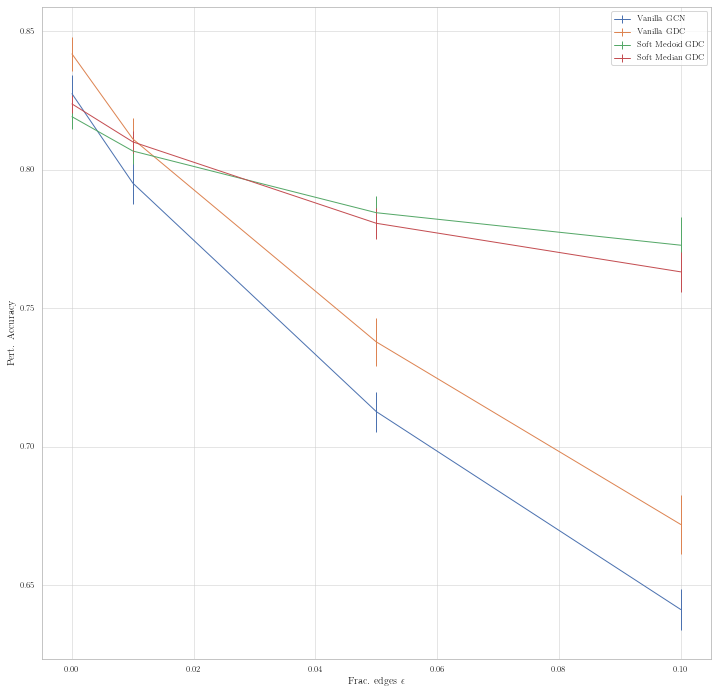

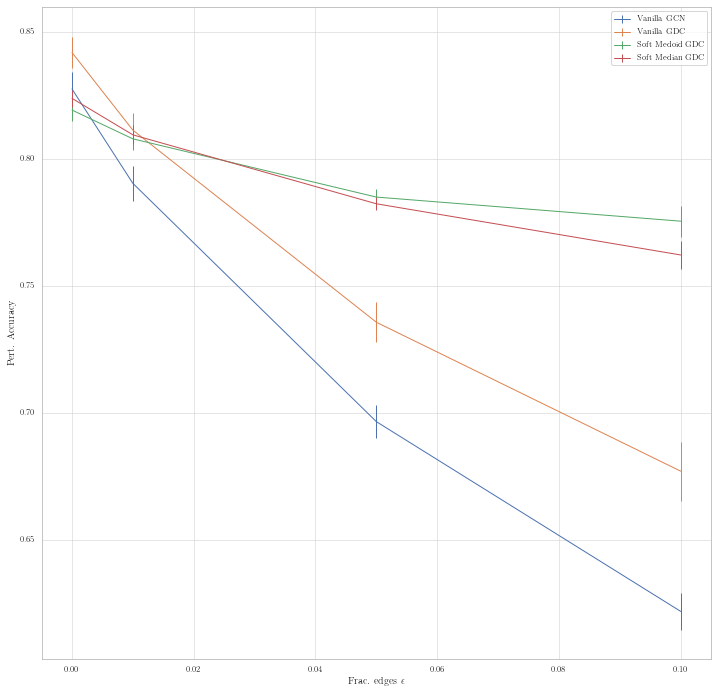

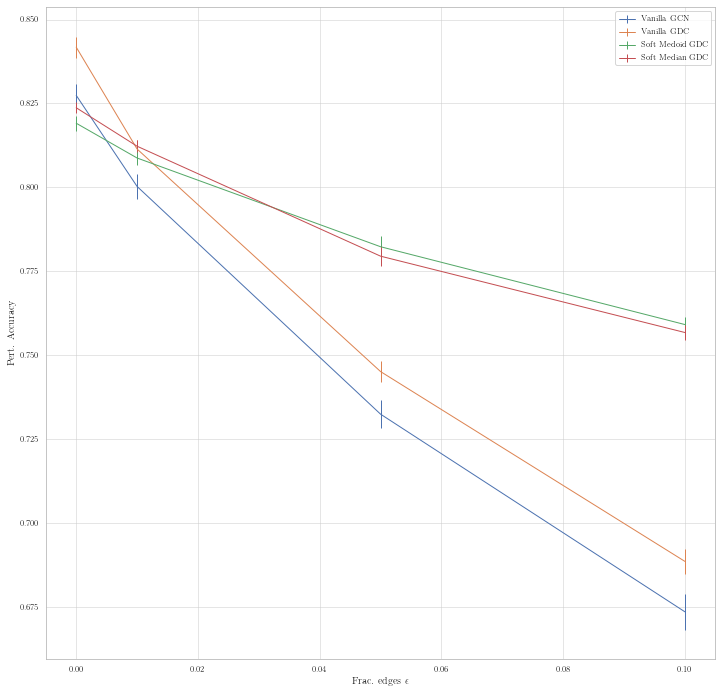

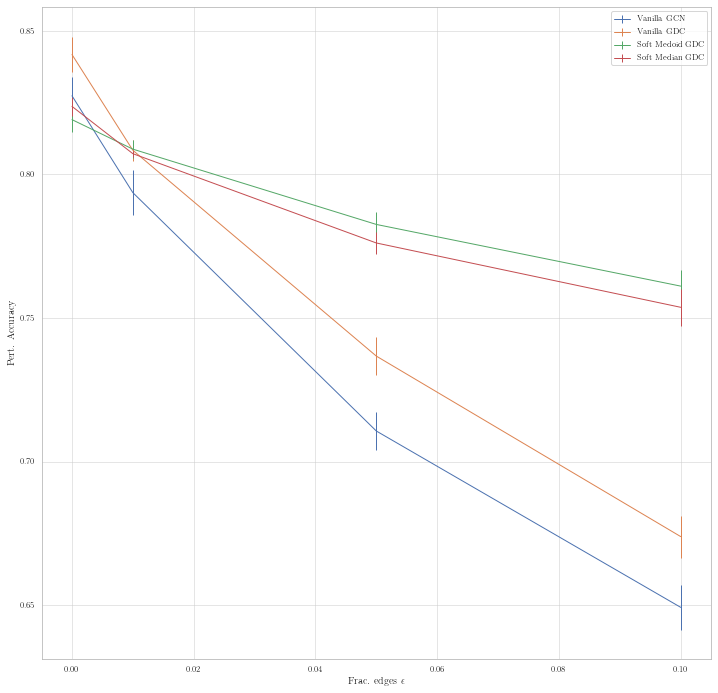

In [182]:
for (dataset, attack), df_group in df_results[
    (df_results['novel_loss']
     | (df_results['attack'] == 'DICE')
     | (df_results['attack'] == 'GANG'))
    & ~((df_results['dataset'] == 'ogbn-products') & (df_results['label'] == 'Soft Median GDC (T=0.2)'))
    & ~((df_results['dataset'] != 'ogbn-products') & (df_results['label'] == 'Soft Median GDC (T=0.5)'))
    & ((df_results['dataset'] != 'ogbn-arxiv') | (df_results['label'] != 'Soft Median GDC (T=5.0)'))
    & df_results['attack'].isin(attacks)
    & (df_results['epsilon'] <= 0.1)
    # Filter out the SVD outlier where it fails catastrophically
    & ((df_results.dataset != 'citeseer') | (df_results.label != 'SVD GCN') | (df_results.accuracy > 0.1))
].groupby(['dataset', 'attack']):       
    print(dataset, attack)
    
    fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)

    for label in labels_non_batched + lables_batched:        
        if df_group[df_group.label == label].shape[0] == 0:
            continue
           
        df_values = df_group[df_group.label == label].groupby('epsilon').accuracy.agg(['mean', 'sem']).reset_index()
        
        plt.errorbar(
            df_values.epsilon,
            df_values['mean'],
            df_values['sem'],
            label=label.replace(' (T=5.0)', '').replace(' (T=0.5)', '').replace(' (T=0.2)', '')
        )
    
    df_range = df_group.groupby('epsilon').accuracy.agg(['min', 'max']).reset_index()
    df_range['dataset'] = dataset
    df_range['attack'] = attack    
    
    plt.xlabel(epsilons_c)
    plt.ylabel('Pert. Accuracy')
    
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy_no_legend', fig, close_fig=False)
    ax.legend()
    
    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_transfer_{attack}_{dataset}_pertaccuracy_legend',
        mod_label=lambda l: l,
        ncol=3
    )
    

## Split table for small datasets

In [124]:
small_datasets = [rf'\rotatebox{{90}}{{{d}}}' for d in [dataset_map['cora_ml'], dataset_map['citeseer']]]
small_datasets

['\\rotatebox{90}{\\textbf{Cora ML}}', '\\rotatebox{90}{\\textbf{Citeseer}}']

In [125]:
small_datasets = small_datasets[:-1]
small_datasets

['\\rotatebox{90}{\\textbf{Cora ML}}']

In [126]:
drop_attacks = [attack_map['DICE']]
drop_attacks

['\\textbf{DICE}']

In [127]:
df_small = df_piv.loc[(slice(*small_datasets), slice(None))].drop(columns=drop_attacks)
df_small

/nfs/staff-ssd/geisler/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\textbf{Attack}                                        \textbf{greedy FGSM}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                  0.01   
                                 \textbf{Architecture}                        
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                          0.032   
                                 Vanilla GDC                          0.031   
                                 SVD GCN                 \underline{-0.002}   
                                 Jaccard GCN                          0.027   
                                 RGCN                        \textbf{0.023}   
                                 Soft Medoid GDC                      0.011   
                                 Soft Median GDC                      0.014   

\textbf{Attack}                                                            \
Frac. edges \(\boldsymbol{\epsilon}\)                                0.05   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.115   
                                 Vanilla GDC               \textbf{0.104}   
                                 SVD GCN                \underline{0.012}   
                                 Jaccard GCN                        0.096   
                                 RGCN                      \textbf{0.095}   
                                 Soft Medoid GDC                    0.035   
                                 Soft Median GDC                    0.043   

\textbf{Attack}                                                            \
Frac. edges \(\boldsymbol{\epsilon}\)                                 0.1   
                                 \textbf{Architecture}                      
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                        0.186   
                                 Vanilla GDC                \textbf{0.17}   
                                 SVD GCN                \underline{0.026}   
                                 Jaccard GCN                        0.156   
                                 RGCN                      \textbf{0.159}   
                                 Soft Medoid GDC                    0.046   
                                 Soft Median GDC                    0.061   

\textbf{Attack}                                        \textbf{GR-BCD (ours)}  \
Frac. edges \(\boldsymbol{\epsilon}\)                                    0.01   
                                 \textbf{Architecture}                          
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                   \textbf{0.036}   
                                 Vanilla GDC                   \textbf{0.069}   
                                 SVD GCN                       \textbf{0.527}   
                                 Jaccard GCN                   \textbf{0.525}   
                                 RGCN                        \underline{0.02}   
                                 Soft Medoid GDC               \textbf{0.068}   
                                 Soft Median GDC               \textbf{0.065}   

\textbf{Attack}                                                                     \
Frac. edges \(\boldsymbol{\epsilon}\)                                         0.05   
                                 \textbf{Architecture}                               
\rotatebox{90}{\textbf{Cora ML}} Vanilla GCN                         \textbf{0.13}   
                                 Vanilla GDC                                 0.068   
                                 SVD GCN                            \textbf{0.527}   
                                 Jaccard GCN                        \textbf{0.525}   
                                 RGCN                                        0.088   
                                 Soft Medoid GDC                    \textbf{0.069}   
                                 Soft Median GDC        \underline{\textbf{0.065}}

In [128]:
print(df_small\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.', 
        label='tab:global_small',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llccccccccccccc'
    )
)

\begin{table}
\centering
\caption{Perturbed accuracy for the proposed attacks (see Sections~\ref{sec:attackkdd}-\ref{sec:prbcd}) and baselines on all datasets (see Table~\ref{tab:datasets}). \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). The last column contains the clean accuracy. As this a work-in-progress report, the experiments for the defenses on the large datasets are due and on Products we did not optimize the hyperparameters for GANG. For each architecture we italicize the strongest attack where \(\epsilon=0.05\), underline where \(\epsilon=0.1\), and embolden where \(\epsilon=0.25\). From an attack perspective, a lower perturbed accuracy is better. We rerun the experiments with three different seeds. For OGB we use the provided data splits and otherwise we use random split with 20 nodes per class.}
\label{tab:global_small}
\begin{tabular}{llccccccccccccc}
\toprule
                                 & \textbf{Attack} & \multicolumn{3}{l}{\text

## Split table for large datasets

In [129]:
large_datasets = [rf'\rotatebox{{90}}{{{d}}}' for d in [dataset_map['pubmed'], dataset_map['ogbn-arxiv'], dataset_map['ogbn-products']]]
large_datasets

['\\rotatebox{90}{\\textbf{PubMed}}',
 '\\rotatebox{90}{\\textbf{arXiv}}',
 '\\rotatebox{90}{\\textbf{Products}}']

In [130]:
drop_attacks = [attack_map['FGSM'], attack_map['PGD']]
drop_attacks

['\\textbf{greedy FGSM}', '\\textbf{PGD}']

In [131]:
df_large = df_piv.loc[(slice(large_datasets[0], large_datasets[-1]), slice(None))].drop(columns=drop_attacks)
df_large

TypeError: Level type mismatch: \rotatebox{90}{\textbf{PubMed}}

In [132]:
print(df_large\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'\todo{Sth}', 
        label='tab:global_small',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='llcccccccccc'
    )
)

NameError: name 'df_large' is not defined

# Compare losses

In [245]:
architecture_c = r'\textbf{Architecture}'
dataset_c = r'   '
attack_c = r'\rotatebox{90}{\textbf{Attack}}'
epsilons_c = r'\makecell{\textbf{Frac.}\\\textbf{edges}\\\(\boldsymbol{\epsilon}\)}'

epsilons = [0.01, 0.05, 0.1]
epsilon_marks = ['', r'\textit', r'\underline', r'\textbf']

In [243]:
loss_c = r'\textbf{Loss}'

loss_map = {
    'CE': 'CE',
    'CW': 'CW',
    'SCE': 'SCE',
    'MCE': 'MCE',
    'tanhMargin': 'tanh Margin',
    'Margin': 'Margin',
    'eluMargin': 'elu Margin',
    #'tanhMarginCW-0.25': '0.25 tanh Margin + 0.75 CW',
    #'tanhMarginCW-0.5': '0.5 tanh Margin + 0.5 CW',
    #'tanhMarginCW-0.625': '0.625 tanh Margin + 0.375 CW',
    #'tanhMarginCW-0.75': '0.75 tanh Margin + 0.25 CW',
    #'tanhMarginCW-0.9': '0.9 tanh Margin + 0.1 CW',
    #'tanhMarginCW-0.95': '0.95 tanh Margin + 0.05 CW',
    #'tanhMarginMCE-0.25': '0.25 tanh Margin + 0.75 MCE',
    'tanhMarginMCE-0.5': '0.5 tanh Margin + 0.5 MCE',
    #'tanhMarginMCE-0.625': '0.625 tanh Margin + 0.375 MCE',
    'tanhMarginMCE-0.75': '0.75 tanh Margin + 0.25 MCE',
    #'tanhMarginMCE-0.9': '0.9 tanh Margin + 0.1 MCE',
    #'tanhMarginMCE-0.95': '0.95 tanh Margin + 0.05 MCE',
}


def loss_str(loss: str) -> str:
    if isinstance(loss, str):
        return loss_map[loss]
    else:
        return loss_map['CE']
    
def transform_label(label: str):
    label = label.replace('\n', ' ').replace(' (T=0.5)','').replace(' (T=0.2)','').replace(' ', r'\\')
    return f'\makecell{{{label}}}'

In [226]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, df_experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = df_experiment['config.dataset']
    df_result['attack'] = df_experiment['config.attack']
    df_result['seed'] = df_experiment['config.seed']
    df_result['batch_id'] = df_experiment['batch_id']
    df_result['loss'] = loss_str(df_experiment['config.attack_params.loss_type'])
    df_result['lr'] = df_experiment['config.attack_params.base_lr']

df_results = pd.concat(df_results, ignore_index=True)
df_results = df_results.sort_values('batch_id')
df_results = df_results.drop_duplicates([
    c for c in df_results.columns if c != 'batch_id' and c != 'accuracy'
], keep='last')

df_results

,label,epsilon,accuracy,dataset,attack,seed,batch_id,loss,lr
0,Vanilla GCN,0.00,0.815020,cora_ml,FGSM,0,1,CE,NaN
6267,SVD GCN (rank=100),0.25,0.647036,cora_ml,PGD,1,1,0.9 tanh Margin + 0.1 CW,0.001
6268,Jaccard GCN,0.25,0.590909,cora_ml,PGD,1,1,0.9 tanh Margin + 0.1 CW,0.001
6269,RGCN,0.25,0.615020,cora_ml,PGD,1,1,0.9 tanh Margin + 0.1 CW,0.001
6270,Vanilla GCN,0.00,0.829644,cora_ml,PGD,1,1,0.9 tanh Margin + 0.05 CW,0.050
...,...,...,...,...,...,...,...,...,...
15448,Soft Median GDC (T=1.0),0.25,0.656126,cora_ml,PGD,0,3,0.9 tanh Margin + 0.05 MCE,0.100
15447,Soft Medoid GDC (T=0.5),0.25,0.739130,cora_ml,PGD,0,3,0.9 tanh Margin + 0.05 MCE,0.100
15446,Vanilla GDC,0.25,0.586957,cora_ml,PGD,0,3,0.9 tanh Margin + 0.05 MCE,0.100
15468,Vanilla GDC,0.01,0.816996,cora_ml,PGD,1,3,CE,1.000


In [227]:
df = []

for (dataset, attack, label, epsilon, loss), df_group in df_results[
    df_results['attack'].isin(['FGSM', 'PGD'])
    & df_results['label'].isin(labels_to_plot)
].groupby(['dataset', 'attack', 'label', 'epsilon', 'loss']):
    if len(df_group.seed.unique()) != 3:
        print(f'For {dataset}-{attack}-{epsilon} collected runs for seed {df_group.seed.tolist()}')

    accuracy = calc_mean_and_error(df_group.accuracy, df_group.seed, with_error=False, decimal_places=4)
    df.append({
        dataset_c: dataset_map[dataset],
        architecture_c: transform_label(label),
        attack_c: attack_map[attack],
        epsilons_c: epsilon,
        'accuracy': accuracy,
        loss_c: loss
    })
    
df = pd.DataFrame(df)

df = df[
    df[attack_c].isin([attack_map['PGD'], attack_map['FGSM']])
    & ~((df[attack_c] == attack_map['PGD']) & (df[dataset_c] == dataset_map['pubmed']))
    & ~((df[attack_c] == attack_map['FGSM']) & (df[dataset_c] == dataset_map['pubmed']))
]

df = df[df[epsilons_c].isin(epsilons)].copy()

df

,,\textbf{Architecture},\rotatebox{90}{\textbf{Attack}},\makecell{\textbf{Frac.}\\\textbf{edges}\\\(\boldsymbol{\epsilon}\)},accuracy,\textbf{Loss}
19,\textbf{Cora ML},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.8020,0.25 tanh Margin + 0.75 CW
20,\textbf{Cora ML},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7881,0.25 tanh Margin + 0.75 MCE
21,\textbf{Cora ML},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7963,0.5 tanh Margin + 0.5 CW
22,\textbf{Cora ML},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7881,0.5 tanh Margin + 0.5 MCE
23,\textbf{Cora ML},\makecell{Jaccard\\GCN},\textbf{greedy FGSM},0.01,0.7928,0.625 tanh Margin + 0.375 CW
...,...,...,...,...,...,...
1515,\textbf{Cora ML},\makecell{Vanilla\\GDC},\textbf{PGD},0.25,0.7105,MCE
1516,\textbf{Cora ML},\makecell{Vanilla\\GDC},\textbf{PGD},0.25,0.6534,Margin
1517,\textbf{Cora ML},\makecell{Vanilla\\GDC},\textbf{PGD},0.25,0.7099,SCE
1518,\textbf{Cora ML},\makecell{Vanilla\\GDC},\textbf{PGD},0.25,0.6835,elu Margin


In [228]:
df[architecture_c] = df[architecture_c].astype("category")
df[architecture_c].cat.set_categories(
    [transform_label(l) for l in labels_to_plot],
    inplace=True
)
df[dataset_c] = df[dataset_c].astype("category")
df[dataset_c].cat.set_categories(
    dataset_order,
    inplace=True
)
df[attack_c] = df[attack_c].astype("category")
df[attack_c].cat.set_categories(
    list(attack_map.values()),
    inplace=True
)
df[attack_c] = df[attack_c].cat.rename_categories([rf'\rotatebox{{90}}{{{cat}}}' for cat in df[attack_c].cat.categories])

df_piv = pd.pivot_table(
    df, 
    index=[attack_c, epsilons_c, loss_c], 
    columns=[dataset_c, architecture_c],
    values='accuracy',
    aggfunc=lambda x: ' '.join(x)
)

#df_piv = df_piv[[c for attack in attack_order for c in df_piv.columns if c[0] == attack]]

#for epsilon, mark in zip(epsilons, epsilon_marks):
#    current_columns = [c for c in df_piv.columns if c[1] == epsilon]
#    df_piv[current_columns] = df_piv[current_columns].groupby(dataset_c).apply(
#        partial(mark_best_and_second_best, first_mark=mark, second_mark='', axis=1, is_higher_better=False)
#    )

#def acc_to_mean_and_error(group: pd.DataFrame, with_error=True, decimal_places: int = 3):
#    return calc_mean_and_error(group['accuracy'], group['seed'], with_error=with_error, decimal_places=decimal_places)

#df_piv = df_piv.join(df_accuracy)
df_piv = df_piv.fillna('-')

ce_acc = df_piv.xs(loss_map['CE'], level=2, drop_level=False).values
nonce_acc = np.vstack([
    df_piv.xs(loss_map[loss], level=2, drop_level=False).values
    for loss in loss_map.keys() if loss != loss_map['CE']
])

row_idx = len(loss_map) * np.arange(df_piv.shape[0] // len(loss_map))
row_idx = (row_idx[:, None] 
           + df_piv.groupby(level=[0,1]).aggregate(lambda col: col.astype(float).argmin()).values
          ).flatten()

col_idx = np.tile(np.arange(df_piv.shape[1]), df_piv.shape[0] // len(loss_map))

mask = np.zeros(df_piv.shape).astype(bool)
mask[row_idx, col_idx] = True

df_piv = df_piv.mask(
    pd.DataFrame(mask, columns=df_piv.columns, index=df_piv.index),
    df_piv.applymap(lambda elem: rf'{epsilon_marks[-1]}{{{elem}}}')
)
df_piv

\textbf{Cora ML}  \
\textbf{Architecture}                                                                                                 \makecell{Vanilla\\GCN}   
\rotatebox{90}{\textbf{Attack}}      \makecell{\textbf{Frac.}\\\textbf{edges}\\\(\bo... \textbf{Loss}                                           
\rotatebox{90}{\textbf{greedy FGSM}} 0.01                                               0.25 tanh Margin + 0.75 CW                     0.8116   
                                                                                        0.25 tanh Margin + 0.75 MCE           \textbf{0.7921}   
                                                                                        0.5 tanh Margin + 0.5 CW                       0.8040   
                                                                                        0.5 tanh Margin + 0.5 MCE                      0.7925   
                                                                                        0.625 tanh Margin + 0.375 CW                   0.7976   
                                                                                        0.625 tanh Margin + 0.375 MCE                  0.7945   
                                                                                        0.75 tanh Margin + 0.25 CW                     0.7945   
                                                                                        0.75 tanh Margin + 0.25 MCE                    0.7967   
                                                                                        0.9 tanh Margin + 0.05 CW                      0.7997   
                                                                                        0.9 tanh Margin + 0.05 MCE                     0.7997   
                                                                                        0.9 tanh Margin + 0.1 CW                       0.7974   
                                                                                        0.9 tanh Margin + 0.1 MCE                      0.7996   
                                                                                        CE                                             0.8142   
                                                                                        CW                                             0.8138   
                                                                                        MCE                                            0.7951   
                                                                                        Margin                                         0.8132   
                                                                                        SCE                                            0.8181   
                                                                                        elu Margin                                     0.8138   
                                                                                        tanh Margin                                    0.8012   
                                     0.05                                               0.25 tanh Margin + 0.75 CW                     0.7451   
                                                                                        0.25 tanh Margin + 0.75 MCE                    0.6959   
                                                                                        0.5 tanh Margin + 0.5 CW                       0.7196   
                                                                                        0.5 tanh Margin + 0.5 MCE             \textbf{0.6945}   
                                                                                        0.625 tanh Margin + 0.375 CW                   0.7062   
                                                                                        0.625 tanh Margin + 0.375 MCE                  0.7000   
                                                                 

In [229]:
print(df_piv\
    .sort_index(level=1, ascending=False, sort_remaining=False)\
    .sort_index(level=0, ascending=True, sort_remaining=True)\
    .to_latex(
        float_format='%.2f',
        caption=r'Perturbed accuracy comparing the conventional losses with our loss. \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). We use random split with 20 nodes per class.', 
        label='tab:losscompare',
        escape=False,
        multirow=True,
        multicolumn=True,
        column_format='lcl|cccccccccc|cccccccccc'
    )
)

\begin{table}
\centering
\caption{Perturbed accuracy comparing the conventional losses with our loss. \(\epsilon\) denotes the fraction of edges perturbed (relative to the clean graph). We use random split with 20 nodes per class.}
\label{tab:losscompare}
\begin{tabular}{lcl|cccccccccc|cccccccccc}
\toprule
                             &      &     & \multicolumn{8}{l}{\textbf{Cora ML}} \\
                             &      & \textbf{Architecture} & \makecell{Vanilla\\GCN} & \makecell{Vanilla\\GDC} & \makecell{SVD\\GCN\\(rank=50)} & \makecell{SVD\\GCN\\(rank=100)} & \makecell{Jaccard\\GCN} &  \makecell{RGCN} & \makecell{Soft\\Medoid\\GDC} & \makecell{Soft\\Median\\GDC} \\
\rotatebox{90}{\textbf{Attack}} & \makecell{\textbf{Frac.}\\\textbf{edges}\\\(\boldsymbol{\epsilon}\)} & \textbf{Loss} &                         &                         &                                &                                 &                         &                  &                              &    

## Plot selected

In [230]:
epsilons_c = r'Frac. edges $\epsilon$'

In [241]:
labels_selected = [
    'Vanilla GCN',
    #'Vanilla GDC',
    #'SVD GCN',
    #'Jaccard GCN',
    #'RGCN',
    #'Soft Medoid GDC (T=0.5)',
    #'Soft Median GDC (T=0.2)'
]

datasets_selected = ['citeseer', 'cora_ml']

In [232]:
df_results.loss.unique()

array(['CE', '0.9 tanh Margin + 0.1 CW', '0.9 tanh Margin + 0.05 CW',
       '0.75 tanh Margin + 0.25 CW', '0.625 tanh Margin + 0.375 CW',
       'SCE', 'CW', 'MCE', 'tanh Margin', 'Margin', 'elu Margin',
       '0.5 tanh Margin + 0.5 CW', '0.25 tanh Margin + 0.75 CW',
       '0.75 tanh Margin + 0.25 MCE', '0.9 tanh Margin + 0.1 MCE',
       '0.9 tanh Margin + 0.05 MCE', '0.5 tanh Margin + 0.5 MCE',
       '0.625 tanh Margin + 0.375 MCE', '0.25 tanh Margin + 0.75 MCE'],
      dtype=object)

In [233]:
df_results


,label,epsilon,accuracy,dataset,attack,seed,batch_id,loss,lr
0,Vanilla GCN,0.00,0.815020,cora_ml,FGSM,0,1,CE,NaN
6267,SVD GCN (rank=100),0.25,0.647036,cora_ml,PGD,1,1,0.9 tanh Margin + 0.1 CW,0.001
6268,Jaccard GCN,0.25,0.590909,cora_ml,PGD,1,1,0.9 tanh Margin + 0.1 CW,0.001
6269,RGCN,0.25,0.615020,cora_ml,PGD,1,1,0.9 tanh Margin + 0.1 CW,0.001
6270,Vanilla GCN,0.00,0.829644,cora_ml,PGD,1,1,0.9 tanh Margin + 0.05 CW,0.050
...,...,...,...,...,...,...,...,...,...
15448,Soft Median GDC (T=1.0),0.25,0.656126,cora_ml,PGD,0,3,0.9 tanh Margin + 0.05 MCE,0.100
15447,Soft Medoid GDC (T=0.5),0.25,0.739130,cora_ml,PGD,0,3,0.9 tanh Margin + 0.05 MCE,0.100
15446,Vanilla GDC,0.25,0.586957,cora_ml,PGD,0,3,0.9 tanh Margin + 0.05 MCE,0.100
15468,Vanilla GDC,0.01,0.816996,cora_ml,PGD,1,3,CE,1.000


In [247]:
for (dataset, attack, label, lr), df_group in df_results[
    df_results['attack'].isin(['FGSM', 'PGD'])
    & df_results['label'].isin(labels_selected)
    & df_results['dataset'].isin(datasets_selected)
    & (df_results['epsilon'] <= 0.1)
].fillna(-1).groupby(['dataset', 'attack', 'label', 'lr']):       
    print(loss_composite, dataset, attack, label, lr)

    fig, ax = mpl_latex.newfig(width=0.25, ratio_yx=1)

    for loss in loss_map.values():

        if df_group[df_group.loss == loss].shape[0] == 0:
            continue

        df_values = df_group[df_group.loss == loss].groupby('epsilon').accuracy.agg(['mean', 'sem']).reset_index()

        plt.errorbar(
            df_values.epsilon,
            df_values['mean'],
            df_values['sem'],
            label=loss
        )

    plt.xlabel(epsilons_c)
    if dataset == 'cora_ml':
        plt.ylim(0.4, 0.85)
    else:
        plt.ylim(0.5, 0.725)


    if label != 'Vanilla GCN':
        ax.get_yaxis().set_ticklabels([])

    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_no_leglab', fig, close_fig=False)
    plt.ylabel('Pert. Accuracy')

    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_no_legend', fig, close_fig=False)
    ax.legend()

    mpl_latex.savefig(f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_transfer_{attack}_{dataset}_{label}_surrloss_legend',
        mod_label=lambda l: l,
        ncol=5
    )

False cora_ml FGSM Vanilla GCN -1.0
False cora_ml PGD Vanilla GCN 0.001
False cora_ml PGD Vanilla GCN 0.01
False cora_ml PGD Vanilla GCN 0.05
False cora_ml PGD Vanilla GCN 0.1
False cora_ml PGD Vanilla GCN 1.0


RuntimeError: latex was not able to process the following string:
b'\\\\makecell{\\\\textbf{Frac.}\\\\\\\\\\\\textbf{edges}\\\\\\\\\\\\(\\\\boldsymbol{\\\\epsilon}\\\\)}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/nfs/homedirs/geisler/.cache/matplotlib/tex.cache/7fdb769e1b9c4af216ba05a4364c
589e.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./7fdb769e1b9c4af216ba05a4364c589e.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.17 ...{10.000000}{12.500000}{\rmfamily \makecell
                                                  {\textbf{Frac.}\\\textbf{e...
No pages of output.
Transcript written on 7fdb769e1b9c4af216ba05a4364c589e.log.




<Figure size 864x864 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'\\\\makecell{\\\\textbf{Frac.}\\\\\\\\\\\\textbf{edges}\\\\\\\\\\\\(\\\\boldsymbol{\\\\epsilon}\\\\)}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/nfs/homedirs/geisler/.cache/matplotlib/tex.cache/7fdb769e1b9c4af216ba05a4364c
589e.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./7fdb769e1b9c4af216ba05a4364c589e.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.17 ...{10.000000}{12.500000}{\rmfamily \makecell
                                                  {\textbf{Frac.}\\\textbf{e...
No pages of output.
Transcript written on 7fdb769e1b9c4af216ba05a4364c589e.log.




<Figure size 864x864 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'\\\\makecell{\\\\textbf{Frac.}\\\\\\\\\\\\textbf{edges}\\\\\\\\\\\\(\\\\boldsymbol{\\\\epsilon}\\\\)}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/nfs/homedirs/geisler/.cache/matplotlib/tex.cache/7fdb769e1b9c4af216ba05a4364c
589e.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./7fdb769e1b9c4af216ba05a4364c589e.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.17 ...{10.000000}{12.500000}{\rmfamily \makecell
                                                  {\textbf{Frac.}\\\textbf{e...
No pages of output.
Transcript written on 7fdb769e1b9c4af216ba05a4364c589e.log.




<Figure size 864x864 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'\\\\makecell{\\\\textbf{Frac.}\\\\\\\\\\\\textbf{edges}\\\\\\\\\\\\(\\\\boldsymbol{\\\\epsilon}\\\\)}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/nfs/homedirs/geisler/.cache/matplotlib/tex.cache/7fdb769e1b9c4af216ba05a4364c
589e.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./7fdb769e1b9c4af216ba05a4364c589e.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.17 ...{10.000000}{12.500000}{\rmfamily \makecell
                                                  {\textbf{Frac.}\\\textbf{e...
No pages of output.
Transcript written on 7fdb769e1b9c4af216ba05a4364c589e.log.




<Figure size 864x864 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'\\\\makecell{\\\\textbf{Frac.}\\\\\\\\\\\\textbf{edges}\\\\\\\\\\\\(\\\\boldsymbol{\\\\epsilon}\\\\)}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/nfs/homedirs/geisler/.cache/matplotlib/tex.cache/7fdb769e1b9c4af216ba05a4364c
589e.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./7fdb769e1b9c4af216ba05a4364c589e.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.17 ...{10.000000}{12.500000}{\rmfamily \makecell
                                                  {\textbf{Frac.}\\\textbf{e...
No pages of output.
Transcript written on 7fdb769e1b9c4af216ba05a4364c589e.log.




<Figure size 864x864 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'\\\\makecell{\\\\textbf{Frac.}\\\\\\\\\\\\textbf{edges}\\\\\\\\\\\\(\\\\boldsymbol{\\\\epsilon}\\\\)}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/nfs/homedirs/geisler/.cache/matplotlib/tex.cache/7fdb769e1b9c4af216ba05a4364c
589e.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./7fdb769e1b9c4af216ba05a4364c589e.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.17 ...{10.000000}{12.500000}{\rmfamily \makecell
                                                  {\textbf{Frac.}\\\textbf{e...
No pages of output.
Transcript written on 7fdb769e1b9c4af216ba05a4364c589e.log.




<Figure size 864x864 with 1 Axes>

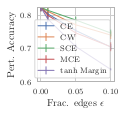

In [132]:
plt.gcf()

# Datasets

In [44]:
def value_to_storage(val: float, decimals: int = 2):
    if val / 1e3 < 1:
        return f'{val:.{decimals}f} B'
    if val / 1e6 < 1:
        return f'{val / 1e3:.{decimals}f} kB'
    if val / 1e9 < 1:
        return f'{val / 1e6:.{decimals}f} MB'
    if val / 1e12 < 1:
        return f'{val / 1e9:.{decimals}f} GB'
    if val / 1e15 < 1:
        return f'{val / 1e12:.{decimals}f} TB'
    if val / 1e18 < 1:
        return f'{val / 1e15:.{decimals}f} PB'
    raise ValueError(f'{val} is too big for Peta!!!')

In [45]:
from ogb.nodeproppred import PygNodePropPredDataset

from rgnn_at_scale.data import load_dataset

dataset_df = []
for dataset in tqdm.tqdm(['cora_ml', 'citeseer', 'pubmed', 'ogbn-arxiv', 'ogbn-products', 'ogbn-papers100M']):
    if dataset.startswith('ogbn'):
        pyg_dataset = PygNodePropPredDataset(root='/nfs/staff-ssd/geisler/dontrobme/datasets', name=dataset)
        nnodes = pyg_dataset[0].x.shape[0]
        nedges = pyg_dataset[0].edge_index.shape[1]
        nfeatures = pyg_dataset[0].x.shape[1]
    else:
        graph = load_dataset(dataset, '/nfs/staff-ssd/geisler/dontrobme/datasets').standardize(
            make_unweighted=True,
            make_undirected=True,
            no_self_loops=True,
            select_lcc=True
        )
        #graph = load_and_standardize(dataset)
        nnodes = graph.adj_matrix.shape[0]
        nedges = graph.adj_matrix.nnz
        nfeatures = graph.attr_matrix.shape[1]
    dataset_df.append({
            r'\textbf{Dataset}': dataset_map[dataset].replace(r'rotatebox{90}', r'textbf'),
            r'\textbf{\#Nodes $n$}': f'{nnodes:,}',
            r'\textbf{\#Edges $e$}': f'{nedges:,}',
            r'\textbf{\#Features $d$}': f'{nfeatures:,}',
            #r'\textbf{\#Possible edges}': f'{nnodes ** 2:.3E}',
            r'\textbf{Size (dense)}': value_to_storage(4 * nnodes ** 2),
            r'\textbf{Size (sparse)}': value_to_storage(2*8*nedges + 4*nedges),
        })
dataset_df = pd.DataFrame(dataset_df).set_index(r'\textbf{Dataset}')
dataset_df

 83%|████████▎ | 5/6 [00:37<00:07,  7.49s/it]


KeyboardInterrupt: 

In [ ]:
dataset_df.to_dict()

In [ ]:
print(dataset_df
    #.sort_index()
    .to_latex(
        float_format='%.2f',
        caption='Statistics of the used datasets. For the dense adjacency matrix we assume that each elements is represented by 4 bytes. In the sparse case we use two 8 byte integer pointers and a 4 bytes float value.', 
        label='tab:datasets',
        escape=False
    )
)

# PPR

In [ ]:
def ppr(A):
    A_norm = A / A.sum(-1)[:, None]
    return alpha * torch.inverse(torch.eye(4) + (alpha - 1) * A_norm)

def update(A_dense, ppr_original, u, v):
    i = torch.nonzero(u.flatten()).item()
    
    row = A_dense[i] + v
    row = row / row.sum()
    A_norm = A_dense[i] / A_dense[i].sum()
    row_diff = row - A_norm
    row_diff_norm = (alpha - 1) * row_diff
    print(row_diff_norm)

    P_inv = (1 / alpha) * ppr_original
    P_uv_inv = P_inv - (P_inv @ u @ row_diff_norm @ P_inv) / (1 + row_diff_norm @ P_inv @ u)
    ppr_update = alpha * P_uv_inv
    
    return ppr_update

alpha = 0.15
A_dense_list = [
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),    
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 1, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32),    
    torch.tensor([[0, 1, 0, 1],
                  [1, 0, 1, 0],
                  [0, 1, 0, 1],
                  [1, 1, 1, 0]],
                 dtype=torch.float32)
]


u_list = [
    torch.tensor([[0], [0], [1], [0]], dtype=torch.float32),
    torch.tensor([[0], [0], [1], [0]], dtype=torch.float32),
    torch.tensor([[1], [0], [0], [0]], dtype=torch.float32),
    torch.tensor([[0], [1], [0], [0]], dtype=torch.float32),
    torch.tensor([[0], [0], [0], [1]], dtype=torch.float32)
]
v_list = [
    torch.tensor([[0.3, 0.1, 0, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 12, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0.8, 0.3]], dtype=torch.float32, requires_grad=True),
    torch.tensor([[0.3, 0.1, 0.8, 0.3]], dtype=torch.float32, requires_grad=True)
]


for A_dense, u, v in zip(A_dense_list, u_list, v_list):

    ppr_original = ppr(A_dense)
    print(ppr_original)

    A_pert = A_dense + u@v
    print(A_pert)

    ppr_target = ppr(A_dense + u@v)
    print('Soll', ppr_target)

    ppr_update = update(A_dense, ppr_original, u, v)
    print('Ist', ppr_update)

    ppr_update.sum().backward()
    print(v.grad)

    assert torch.allclose(ppr_update, ppr_target)

In [ ]:
for A_dense, u, v in zip(A_dense_list, u_list, v_list):

    ppr_original = ppr(A_dense)
    print(ppr_original)

    A_pert = A_dense + u@v
    print(A_pert)

    ppr_target = ppr(A_dense + u@v)
    print('Soll', ppr_target)

    ppr_update = update(A_dense, ppr_original, u, v)
    print('Ist', ppr_update)

    ppr_update.sum().backward()
    print(v.grad)

    assert torch.allclose(ppr_update, ppr_target)